In [ ]:
!nvidia-smi

In [ ]:
%%capture
!pip install albumentations ipyexperiments pytorch_pfn_extras fastai kaggle
!pip install git+https://github.com/rwightman/pytorch-image-models.git

In [ ]:
%%capture
%env KAGGLE_KEY=441a7e26b0336d350454aa3f429e394c
%env KAGGLE_USERNAME=benihime91
!kaggle competitions download -c kaggle-pog-series-s01e03
!unzip /content/kaggle-pog-series-s01e03.zip

In [1]:
from fastai.vision.all import *
from sklearn.model_selection import StratifiedKFold

from ipyexperiments.ipyexperiments import IPyExperimentsPytorch
import timm
from albumentations.pytorch import ToTensorV2
from tqdm.auto import tqdm
from timm.models import safe_model_name, set_fast_norm

In [2]:
set_seed(42); set_fast_norm()
warnings.filterwarnings('ignore')

## Config

In [3]:
DATA_PATH = Path('/content/corn/')
CSV_PATH = DATA_PATH/'train.csv'
IMAGE_FOLDER = DATA_PATH/'train'

LABELS = sorted(['broken', 'pure', 'discolored', 'silkcut'])
labels_class_map = {v:k for k,v in enumerate(LABELS)}
labels_class_map_rev = {v:k for k,v in labels_class_map.items()}

VIEWS = sorted(['top', 'bottom'])
views_class_map = {v:k for k,v in enumerate(VIEWS)}
views_class_map_rev = {v:k for k,v in views_class_map.items()}

VERSION = "NB_EXP_V2_004"
MODEL = "tf_efficientnetv2_s_in21ft1k"
BS = 32
SZ = 288
EP = 16
LR = 3e-4

MODEL_FOLDER = Path(f"/content/{VERSION}/")
MODEL_FOLDER.mkdir(exist_ok=True)

In [4]:
all_df = pd.read_csv(CSV_PATH)
all_df.head()

folds = all_df.copy()
fold_splits = []

Fold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
for n, (train_index, val_index) in enumerate(Fold.split(folds, folds["label"])):
    fold_splits.append(val_index)
    folds.loc[val_index, 'fold'] = int(n)
folds['fold'] = folds['fold'].astype(int)
folds.head()

,seed_id,view,image,label,fold
0,0,top,train/00000.png,broken,0
1,1,bottom,train/00001.png,pure,3
2,3,top,train/00003.png,broken,2
3,4,top,train/00004.png,pure,3
4,5,top,train/00005.png,discolored,4


## Define Dataset

In [5]:
def get_dls(fold:int):
    item_tfms = [Resize(SZ+16, method=ResizeMethod.Squish), ToTensor]

    augments = aug_transforms(do_flip=True, flip_vert=True, max_rotate=360, max_zoom=1.33, max_lighting=0.1, 
                              p_affine=0.5,  p_lighting=0.5, pad_mode="zeros", xtra_tfms=[RandomErasing(p=0.75)])
    batch_tfms = [IntToFloatTensor, RandomResizedCrop(SZ, min_scale=0.72), *augments, Normalize.from_stats(*imagenet_stats)]
    
    dblock = DataBlock(
        blocks     = (ImageBlock, CategoryBlock(vocab=LABELS)),
        splitter   = IndexSplitter(fold_splits[fold]),
        get_x      = ColReader('image', pref=DATA_PATH),
        get_y      = [ColReader('label')],
        item_tfms  = item_tfms,
        batch_tfms = batch_tfms )
    
    dls = dblock.dataloaders(folds, bs=BS)
    return dls

## Visualization

In [6]:
dls = get_dls(0)

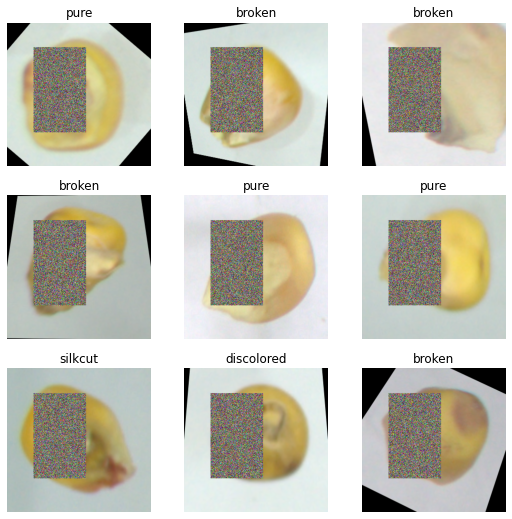

In [7]:
dls.show_batch()

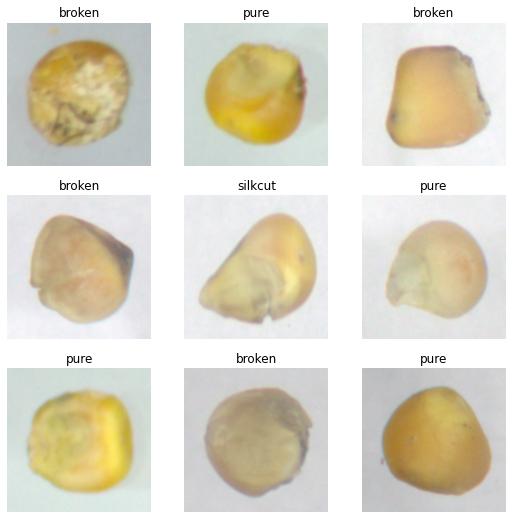

In [8]:
dls.valid.show_batch()

## Learner

In [13]:
def get_learner(fold, model_name, pretrained, **kwargs):
    dls = get_dls(fold)
    
    model = timm.create_model(model_name, pretrained=pretrained, **kwargs)
    model = nn.Sequential(model, nn.Dropout(0.15), nn.Linear(model.num_classes, len(LABELS)))
    
    learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), metrics=[accuracy]).to_fp16()
    return dls, learn


*** Experiment started with the Pytorch backend
Device: ID 0, Tesla P100-PCIE-16GB (16280 RAM)



SuggestedLRs(valley=0.00013182566908653826)
CPU: 582/2/3059 MB | GPU: 572/4790/1423 MB | Time 0:00:45.968 | (Consumed/Peaked/Used Total)


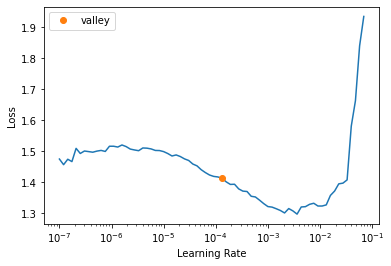

In [12]:
with IPyExperimentsPytorch(exp_enable=False, cl_set_seed=42, cl_compact=True):
    dls, learn = get_learner(0, MODEL, pretrained=True)
    learn.unfreeze()
    print(learn.lr_find())

## Run !

In [14]:
KERNEL_TYPE = f"{MODEL}_{SZ}_bs{BS}_ep{EP}_lr{str(LR).replace('-','')}_mixup_fastai"
print(KERNEL_TYPE)

tf_efficientnetv2_s_in21ft1k_288_bs32_ep16_lr0.0003_mixup_fastai


In [16]:
def training_loop(fold):
    with IPyExperimentsPytorch(exp_enable=False, cl_set_seed=42, cl_compact=True):
        print()
        print('*' * 100)
        print(f'Training fold {fold}')
        print('*' * 100)

        cbs = [SaveModelCallback(monitor="accuracy", comp=np.greater), MixUp(alpha=0.4)]
        
        dls, learn = get_learner(fold, MODEL, pretrained=True)
        learn.unfreeze()
            
        learn.fit_one_cycle(EP, LR, cbs=cbs)

        learn = learn.load("model")
        learn = learn.to_fp32()

        dirpath = MODEL_FOLDER/f'{KERNEL_TYPE}_CV_{fold_idx}'
        learn.save(dirpath, with_opt=False)

In [17]:
for fold_idx in range(5):
    training_loop(fold_idx)


*** Experiment started with the Pytorch backend
Device: ID 0, Tesla P100-PCIE-16GB (16280 RAM)


****************************************************************************************************
Training fold 0
****************************************************************************************************


epoch,train_loss,valid_loss,accuracy,time
0,1.004362,0.842019,0.667016,03:27
1,0.907023,0.682806,0.737871,03:27
2,0.874645,0.628153,0.751483,03:27
3,0.854318,0.594599,0.758813,03:28
4,0.846533,0.637369,0.747644,03:27
5,0.846161,0.613896,0.766143,03:27
6,0.806638,0.564953,0.768237,03:27
7,0.766799,0.568352,0.766841,03:28
8,0.749990,0.519886,0.792670,03:28
9,0.757787,0.532014,0.785340,03:27


Better model found at epoch 0 with accuracy value: 0.6670157313346863.
Better model found at epoch 1 with accuracy value: 0.7378708720207214.
Better model found at epoch 2 with accuracy value: 0.7514834403991699.
Better model found at epoch 3 with accuracy value: 0.7588132619857788.
Better model found at epoch 5 with accuracy value: 0.7661430835723877.
Better model found at epoch 6 with accuracy value: 0.7682373523712158.
Better model found at epoch 8 with accuracy value: 0.7926701307296753.
Better model found at epoch 10 with accuracy value: 0.7937172651290894.
Better model found at epoch 11 with accuracy value: 0.7968586683273315.
Better model found at epoch 12 with accuracy value: 0.8017451763153076.
CPU: 169/7/3229 MB | GPU: 432/4642/1855 MB | Time 0:55:26.446 | (Consumed/Peaked/Used Total)

*** Experiment started with the Pytorch backend
Device: ID 0, Tesla P100-PCIE-16GB (16280 RAM)


************************************************************************************************

epoch,train_loss,valid_loss,accuracy,time
0,1.015213,0.831880,0.676789,03:27
1,0.900988,0.637834,0.748342,03:27
2,0.867409,0.660213,0.738569,03:26
3,0.863344,0.599152,0.761606,03:27
4,0.852949,0.574003,0.782199,03:27
5,0.842022,0.565068,0.775218,03:26
6,0.820582,0.566201,0.780454,03:26
7,0.790731,0.546418,0.786736,03:26
8,0.743395,0.513402,0.791274,03:26
9,0.767170,0.520288,0.795812,03:26


Better model found at epoch 0 with accuracy value: 0.6767888069152832.
Better model found at epoch 1 with accuracy value: 0.7483420372009277.
Better model found at epoch 3 with accuracy value: 0.7616055607795715.
Better model found at epoch 4 with accuracy value: 0.782198965549469.
Better model found at epoch 7 with accuracy value: 0.7867364883422852.
Better model found at epoch 8 with accuracy value: 0.7912740111351013.
Better model found at epoch 9 with accuracy value: 0.7958115339279175.
Better model found at epoch 11 with accuracy value: 0.8055846691131592.
Better model found at epoch 12 with accuracy value: 0.8104711771011353.
CPU: 11/7/3240 MB | GPU: 424/4576/1853 MB | Time 0:55:17.068 | (Consumed/Peaked/Used Total)

*** Experiment started with the Pytorch backend
Device: ID 0, Tesla P100-PCIE-16GB (16280 RAM)


****************************************************************************************************
Training fold 2
*****************************************************

epoch,train_loss,valid_loss,accuracy,time
0,0.995144,0.837982,0.658869,03:26
1,0.879485,0.659710,0.744413,03:27
2,0.893980,0.741052,0.711941,03:27
3,0.854669,0.644432,0.737430,03:27
4,0.820603,0.619329,0.756285,03:26
5,0.824656,0.573837,0.782821,03:26
6,0.802819,0.577614,0.768156,03:27
7,0.772598,0.549348,0.778631,03:27
8,0.744718,0.557121,0.783170,03:27
9,0.743229,0.551079,0.777235,03:27


Better model found at epoch 0 with accuracy value: 0.6588687300682068.
Better model found at epoch 1 with accuracy value: 0.744413435459137.
Better model found at epoch 4 with accuracy value: 0.7562848925590515.
Better model found at epoch 5 with accuracy value: 0.7828212380409241.
Better model found at epoch 8 with accuracy value: 0.7831704020500183.
Better model found at epoch 10 with accuracy value: 0.7957402467727661.
Better model found at epoch 13 with accuracy value: 0.7964385747909546.
CPU: 13/8/3253 MB | GPU: 110/4804/1963 MB | Time 0:55:16.034 | (Consumed/Peaked/Used Total)

*** Experiment started with the Pytorch backend
Device: ID 0, Tesla P100-PCIE-16GB (16280 RAM)


****************************************************************************************************
Training fold 3
****************************************************************************************************


epoch,train_loss,valid_loss,accuracy,time
0,1.014957,0.889757,0.680517,03:26
1,0.890613,0.670323,0.721369,03:26
2,0.892468,0.622291,0.752793,03:26
3,0.870706,0.603742,0.759078,03:26
4,0.852200,0.592126,0.755936,03:26
5,0.839044,0.551681,0.786313,03:26
6,0.809155,0.550732,0.786662,03:27
7,0.784116,0.533613,0.787360,03:26
8,0.773883,0.517706,0.788408,03:26
9,0.751409,0.503501,0.799930,03:26


Better model found at epoch 0 with accuracy value: 0.68051677942276.
Better model found at epoch 1 with accuracy value: 0.7213687300682068.
Better model found at epoch 2 with accuracy value: 0.7527933120727539.
Better model found at epoch 3 with accuracy value: 0.7590782046318054.
Better model found at epoch 5 with accuracy value: 0.7863128781318665.
Better model found at epoch 6 with accuracy value: 0.7866619825363159.
Better model found at epoch 7 with accuracy value: 0.7873603105545044.
Better model found at epoch 8 with accuracy value: 0.7884078025817871.
Better model found at epoch 9 with accuracy value: 0.7999301552772522.
Better model found at epoch 11 with accuracy value: 0.80551677942276.
Better model found at epoch 12 with accuracy value: 0.8065642714500427.
CPU: 6/8/3258 MB | GPU: 426/4570/1859 MB | Time 0:55:12.939 | (Consumed/Peaked/Used Total)

*** Experiment started with the Pytorch backend
Device: ID 0, Tesla P100-PCIE-16GB (16280 RAM)


********************************

epoch,train_loss,valid_loss,accuracy,time
0,1.010590,0.823921,0.672137,03:26
1,0.916501,0.623060,0.757332,03:27
2,0.871394,0.623702,0.762221,03:26
3,0.864544,0.592478,0.767458,03:26
4,0.851889,0.578161,0.773743,03:26
5,0.836818,0.576100,0.778631,03:26
6,0.828700,0.563725,0.767807,03:26
7,0.791867,0.509401,0.796788,03:26
8,0.757791,0.504662,0.799232,03:27
9,0.757565,0.494247,0.806215,03:26


Better model found at epoch 0 with accuracy value: 0.6721368432044983.
Better model found at epoch 1 with accuracy value: 0.7573323845863342.
Better model found at epoch 2 with accuracy value: 0.7622206807136536.
Better model found at epoch 3 with accuracy value: 0.7674580812454224.
Better model found at epoch 4 with accuracy value: 0.7737430334091187.
Better model found at epoch 5 with accuracy value: 0.7786312699317932.
Better model found at epoch 7 with accuracy value: 0.7967877388000488.
Better model found at epoch 8 with accuracy value: 0.7992318272590637.
Better model found at epoch 9 with accuracy value: 0.8062151074409485.
Better model found at epoch 11 with accuracy value: 0.8083100318908691.
Better model found at epoch 12 with accuracy value: 0.8131983280181885.
Better model found at epoch 14 with accuracy value: 0.8149441480636597.
CPU: 4/8/3262 MB | GPU: 422/4578/1851 MB | Time 0:55:12.839 | (Consumed/Peaked/Used Total)


In [20]:
@Transform
def hflip(x: TensorTypes): return x.flip(3)

@Transform
def vflip(x: TensorTypes): return x.flip(2)

In [21]:
folds_val_score = []

with IPyExperimentsPytorch(exp_enable=False, cl_set_seed=42, cl_compact=True):
    
    for fold in range(5):
        CHECKPOINT = MODEL_FOLDER/(KERNEL_TYPE + f"_CV_{fold}.pth")
        print(f'=> load from : {CHECKPOINT}')
        
        dls, learn = get_learner(fold, MODEL, pretrained=False)

        learn.model.load_state_dict(torch.load(CHECKPOINT))

        tst_dl = dls.valid.new()
        
        tst_dl_hflip = dls.valid.new()
        tst_dl_hflip.after_batch.add(hflip)
        
        tst_dl_vflip = dls.valid.new()
        tst_dl_vflip.after_batch.add(vflip)
        
        tst_dl_hlip_vflip = dls.valid.new()
        tst_dl_hlip_vflip.after_batch.add([hflip,vflip])
            
        dls = [tst_dl,tst_dl_hflip,tst_dl_vflip,tst_dl_hlip_vflip]
        n = len(dls)
        learn([event.before_fit, event.before_epoch])
        
        aug_preds = []
        with learn.no_mbar():
            if hasattr(learn,'progress'): learn.progress.mbar = master_bar(list(range(n)))
            
            for i in learn.progress.mbar if hasattr(learn,'progress') else range(n):
                learn.epoch = i
                with dls[i].dataset.set_split_idx(1): preds,targs = learn.get_preds(dl=dls[i], inner=True)
                aug_preds.append(preds[None])
        
        learn.epoch = n
        
        aug_preds = torch.cat(aug_preds)
        aug_preds = aug_preds.mean(0)
        acc = accuracy(aug_preds, targs).item()
        print(f"* Accuracy : {acc}")
        print()
        
        folds_val_score.append(acc)
        learn(event.after_fit)
        
           
print()
print('*' * 100)
print(f'Run summary: ')
print('*' * 100)
print("folds score: ", [np.round(s, 5) for s in folds_val_score])
print("Avg: {:.5f}".format(np.mean(folds_val_score)))
print("Std: {:.5f}".format(np.std(folds_val_score)))


*** Experiment started with the Pytorch backend
Device: ID 0, Tesla P100-PCIE-16GB (16280 RAM)

=> load from : /content/NB_EXP_V2_004/tf_efficientnetv2_s_in21ft1k_288_bs32_ep16_lr0.0003_mixup_fastai_CV_0.pth


* Accuracy : 0.8087260127067566

=> load from : /content/NB_EXP_V2_004/tf_efficientnetv2_s_in21ft1k_288_bs32_ep16_lr0.0003_mixup_fastai_CV_1.pth


* Accuracy : 0.8184991478919983

=> load from : /content/NB_EXP_V2_004/tf_efficientnetv2_s_in21ft1k_288_bs32_ep16_lr0.0003_mixup_fastai_CV_2.pth


* Accuracy : 0.8058659434318542

=> load from : /content/NB_EXP_V2_004/tf_efficientnetv2_s_in21ft1k_288_bs32_ep16_lr0.0003_mixup_fastai_CV_3.pth


* Accuracy : 0.8163408041000366

=> load from : /content/NB_EXP_V2_004/tf_efficientnetv2_s_in21ft1k_288_bs32_ep16_lr0.0003_mixup_fastai_CV_4.pth


* Accuracy : 0.8173882961273193

CPU: 18/10/3280 MB | GPU: 146/596/1571 MB | Time 0:03:45.595 | (Consumed/Peaked/Used Total)

****************************************************************************************************
Run summary: 
****************************************************************************************************
folds score:  [0.80873, 0.8185, 0.80587, 0.81634, 0.81739]
Avg: 0.81336
Std: 0.00508


In [23]:
#!cp -r '/content/NB_EXP_V2_004/' '/content/drive/MyDrive'